In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
num_steps_train_discriminator = 4 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [ ]:
torch.manual_seed(7777)

def generator_loss(generator_output):
    ############ YOUR CODE HERE ##########
     gen_disc_output = discriminator(generator_output)
     loss = criterion(gen_disc_output, label_real(len(gen_disc_output)))
     return loss
    
    
    ######################################
    
def discriminator_loss(discriminator_output_fake, discriminator_output_true):
    ############ YOUR CODE HERE ##########
    loss_fake = criterion(discriminator_output_fake, label_fake(len(discriminator_output_fake)))
    loss_real = criterion(discriminator_output_true, label_real(len(discriminator_output_true)))
    
    return loss_fake, loss_real
    
    ######################################

# Q. Write training loop

118it [01:56,  1.01it/s]


Epoch 1 of 100
Generator loss: 7.13656860, Discriminator loss: 0.08845524


118it [01:55,  1.02it/s]


Epoch 2 of 100
Generator loss: 11.90056700, Discriminator loss: 0.08270580


118it [01:53,  1.04it/s]


Epoch 3 of 100
Generator loss: 11.11139484, Discriminator loss: 0.02980470


118it [01:53,  1.04it/s]


Epoch 4 of 100
Generator loss: 11.04240528, Discriminator loss: 0.03925536


118it [01:53,  1.04it/s]


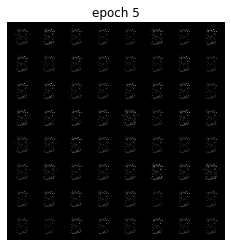

Epoch 5 of 100
Generator loss: 9.63028119, Discriminator loss: 0.00462462


118it [01:54,  1.03it/s]


Epoch 6 of 100
Generator loss: 12.60009334, Discriminator loss: 0.00468090


118it [01:53,  1.04it/s]


Epoch 7 of 100
Generator loss: 13.08803260, Discriminator loss: 0.00235194


118it [01:56,  1.02it/s]


Epoch 8 of 100
Generator loss: 11.93256005, Discriminator loss: 0.00330038


118it [01:54,  1.03it/s]


Epoch 9 of 100
Generator loss: 12.83275309, Discriminator loss: 0.00455457


118it [01:54,  1.03it/s]


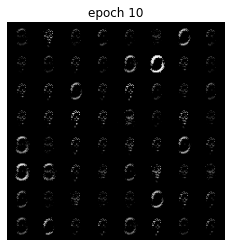

Epoch 10 of 100
Generator loss: 11.14565324, Discriminator loss: 0.02971297


118it [01:55,  1.02it/s]


Epoch 11 of 100
Generator loss: 11.85957527, Discriminator loss: 0.01170414


118it [01:53,  1.04it/s]


Epoch 12 of 100
Generator loss: 12.22283286, Discriminator loss: 0.02515320


118it [01:54,  1.03it/s]


Epoch 13 of 100
Generator loss: 11.53479478, Discriminator loss: 0.01451517


118it [01:54,  1.03it/s]


Epoch 14 of 100
Generator loss: 11.07073648, Discriminator loss: 0.01081362


118it [01:52,  1.05it/s]


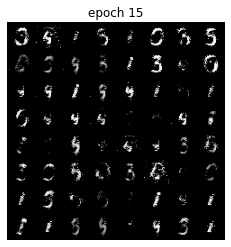

Epoch 15 of 100
Generator loss: 10.40871358, Discriminator loss: 0.03264659


118it [01:54,  1.03it/s]


Epoch 16 of 100
Generator loss: 11.16123878, Discriminator loss: 0.01646328


118it [01:55,  1.02it/s]


Epoch 17 of 100
Generator loss: 10.53842554, Discriminator loss: 0.01548704


118it [01:53,  1.04it/s]


Epoch 18 of 100
Generator loss: 10.73388431, Discriminator loss: 0.01446867


118it [01:55,  1.03it/s]


Epoch 19 of 100
Generator loss: 9.75991447, Discriminator loss: 0.02392494


118it [01:54,  1.03it/s]


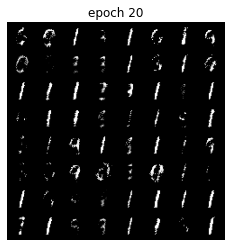

Epoch 20 of 100
Generator loss: 9.51248142, Discriminator loss: 0.02794559


118it [01:53,  1.04it/s]


Epoch 21 of 100
Generator loss: 8.85809038, Discriminator loss: 0.03040231


118it [01:52,  1.04it/s]


Epoch 22 of 100
Generator loss: 8.66829110, Discriminator loss: 0.04217835


118it [01:54,  1.03it/s]


Epoch 23 of 100
Generator loss: 7.85604344, Discriminator loss: 0.04572435


118it [01:56,  1.02it/s]


Epoch 24 of 100
Generator loss: 7.48210653, Discriminator loss: 0.05732147


118it [01:54,  1.03it/s]


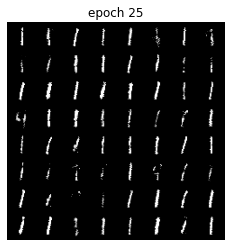

Epoch 25 of 100
Generator loss: 7.11442544, Discriminator loss: 0.06365243


118it [01:55,  1.02it/s]


Epoch 26 of 100
Generator loss: 6.64558664, Discriminator loss: 0.07393452


118it [01:56,  1.01it/s]


Epoch 27 of 100
Generator loss: 6.53251182, Discriminator loss: 0.07144536


118it [01:55,  1.02it/s]


Epoch 28 of 100
Generator loss: 5.95068007, Discriminator loss: 0.08646802


118it [01:56,  1.01it/s]


Epoch 29 of 100
Generator loss: 5.46109504, Discriminator loss: 0.10323497


118it [01:56,  1.01it/s]


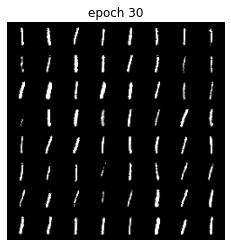

Epoch 30 of 100
Generator loss: 4.87655642, Discriminator loss: 0.13360070


118it [01:54,  1.03it/s]


Epoch 31 of 100
Generator loss: 4.60196276, Discriminator loss: 0.14663337


118it [01:55,  1.02it/s]


Epoch 32 of 100
Generator loss: 4.38879866, Discriminator loss: 0.16038297


118it [01:55,  1.02it/s]


Epoch 33 of 100
Generator loss: 4.05229704, Discriminator loss: 0.18162236


118it [01:54,  1.03it/s]


Epoch 34 of 100
Generator loss: 3.99047951, Discriminator loss: 0.18955957


118it [01:54,  1.03it/s]


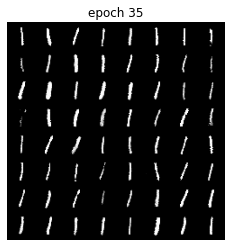

Epoch 35 of 100
Generator loss: 3.88046343, Discriminator loss: 0.19795752


118it [01:54,  1.03it/s]


Epoch 36 of 100
Generator loss: 3.71302674, Discriminator loss: 0.21079930


118it [01:55,  1.02it/s]


Epoch 37 of 100
Generator loss: 3.81423779, Discriminator loss: 0.20564063


118it [01:55,  1.02it/s]


Epoch 38 of 100
Generator loss: 3.63268943, Discriminator loss: 0.21497147


118it [01:54,  1.03it/s]


Epoch 39 of 100
Generator loss: 3.62703734, Discriminator loss: 0.21636214


118it [01:56,  1.02it/s]


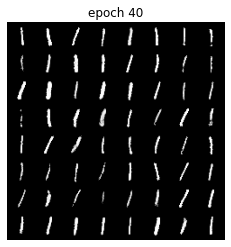

Epoch 40 of 100
Generator loss: 3.52274156, Discriminator loss: 0.22389018


118it [01:55,  1.02it/s]


Epoch 41 of 100
Generator loss: 3.51909773, Discriminator loss: 0.23037940


118it [01:55,  1.02it/s]


Epoch 42 of 100
Generator loss: 3.44433455, Discriminator loss: 0.24028552


118it [01:55,  1.02it/s]


Epoch 43 of 100
Generator loss: 3.48640453, Discriminator loss: 0.24335340


118it [01:54,  1.03it/s]


Epoch 44 of 100
Generator loss: 3.35778082, Discriminator loss: 0.24996992


118it [01:56,  1.01it/s]


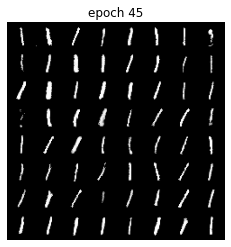

Epoch 45 of 100
Generator loss: 3.37180783, Discriminator loss: 0.25148530


118it [01:54,  1.03it/s]


Epoch 46 of 100
Generator loss: 3.36696630, Discriminator loss: 0.25368502


118it [01:56,  1.01it/s]


Epoch 47 of 100
Generator loss: 3.29878999, Discriminator loss: 0.26428464


118it [01:56,  1.01it/s]


Epoch 48 of 100
Generator loss: 3.19655561, Discriminator loss: 0.26653737


118it [01:55,  1.02it/s]


Epoch 49 of 100
Generator loss: 3.23263419, Discriminator loss: 0.26673780


118it [01:58,  1.00s/it]


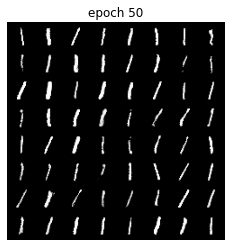

Epoch 50 of 100
Generator loss: 3.17999143, Discriminator loss: 0.27373635


118it [01:55,  1.03it/s]


Epoch 51 of 100
Generator loss: 3.06006265, Discriminator loss: 0.28623448


118it [01:57,  1.00it/s]


Epoch 52 of 100
Generator loss: 3.00860705, Discriminator loss: 0.29324797


118it [01:56,  1.01it/s]


Epoch 53 of 100
Generator loss: 2.97005115, Discriminator loss: 0.29828732


118it [01:56,  1.01it/s]


Epoch 54 of 100
Generator loss: 2.92041292, Discriminator loss: 0.30056257


118it [01:56,  1.01it/s]


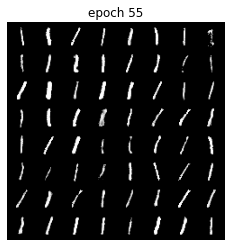

Epoch 55 of 100
Generator loss: 2.89694711, Discriminator loss: 0.30476570


118it [01:55,  1.02it/s]


Epoch 56 of 100
Generator loss: 2.81531125, Discriminator loss: 0.31250211


118it [01:56,  1.01it/s]


Epoch 57 of 100
Generator loss: 2.83301909, Discriminator loss: 0.31320391


118it [01:55,  1.02it/s]


Epoch 58 of 100
Generator loss: 2.82599975, Discriminator loss: 0.31467914


118it [01:57,  1.01it/s]


Epoch 59 of 100
Generator loss: 2.88346973, Discriminator loss: 0.30994731


118it [01:55,  1.02it/s]


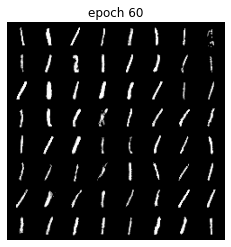

Epoch 60 of 100
Generator loss: 2.85630323, Discriminator loss: 0.31549993


118it [01:55,  1.02it/s]


Epoch 61 of 100
Generator loss: 2.91011862, Discriminator loss: 0.30362175


118it [01:55,  1.02it/s]


Epoch 62 of 100
Generator loss: 2.90762958, Discriminator loss: 0.30834496


118it [01:55,  1.02it/s]


Epoch 63 of 100
Generator loss: 2.85700429, Discriminator loss: 0.31425395


118it [01:56,  1.01it/s]


Epoch 64 of 100
Generator loss: 2.86742277, Discriminator loss: 0.31210729


118it [01:54,  1.03it/s]


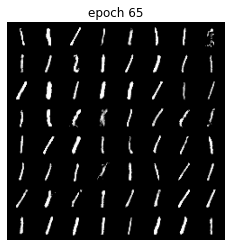

Epoch 65 of 100
Generator loss: 2.81546885, Discriminator loss: 0.31934720


118it [01:55,  1.02it/s]


Epoch 66 of 100
Generator loss: 2.84482572, Discriminator loss: 0.31572764


118it [01:54,  1.03it/s]


Epoch 67 of 100
Generator loss: 2.80449814, Discriminator loss: 0.31927499


118it [01:54,  1.03it/s]


Epoch 68 of 100
Generator loss: 2.85312155, Discriminator loss: 0.31424471


118it [01:54,  1.03it/s]


Epoch 69 of 100
Generator loss: 2.89839669, Discriminator loss: 0.31299198


118it [01:53,  1.04it/s]


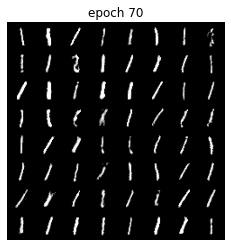

Epoch 70 of 100
Generator loss: 2.84972558, Discriminator loss: 0.31557798


118it [01:55,  1.02it/s]


Epoch 71 of 100
Generator loss: 2.73404740, Discriminator loss: 0.32692451


118it [01:54,  1.03it/s]


Epoch 72 of 100
Generator loss: 2.73109553, Discriminator loss: 0.32662644


118it [01:55,  1.02it/s]


Epoch 73 of 100
Generator loss: 2.80277975, Discriminator loss: 0.32178120


118it [01:55,  1.02it/s]


Epoch 74 of 100
Generator loss: 2.72191960, Discriminator loss: 0.33158514


118it [01:54,  1.03it/s]


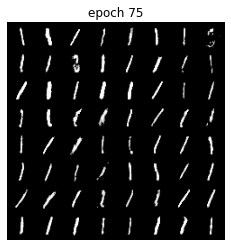

Epoch 75 of 100
Generator loss: 2.77015665, Discriminator loss: 0.32696825


118it [01:56,  1.02it/s]


Epoch 76 of 100
Generator loss: 2.72193188, Discriminator loss: 0.33261732


118it [01:54,  1.03it/s]


Epoch 77 of 100
Generator loss: 2.78480717, Discriminator loss: 0.32577937


118it [01:55,  1.02it/s]


Epoch 78 of 100
Generator loss: 2.70651267, Discriminator loss: 0.33572556


118it [01:54,  1.03it/s]


Epoch 79 of 100
Generator loss: 2.76665993, Discriminator loss: 0.32924603


118it [01:56,  1.01it/s]


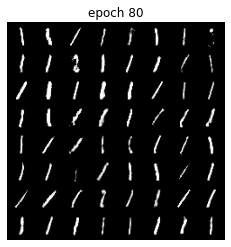

Epoch 80 of 100
Generator loss: 2.68996405, Discriminator loss: 0.33309043


118it [01:55,  1.02it/s]


Epoch 81 of 100
Generator loss: 2.67560443, Discriminator loss: 0.33732453


118it [01:55,  1.02it/s]


Epoch 82 of 100
Generator loss: 2.69898136, Discriminator loss: 0.33822340


118it [01:55,  1.02it/s]


Epoch 83 of 100
Generator loss: 2.69002530, Discriminator loss: 0.34020160


118it [01:55,  1.03it/s]


Epoch 84 of 100
Generator loss: 2.64927047, Discriminator loss: 0.34514455


118it [01:56,  1.01it/s]


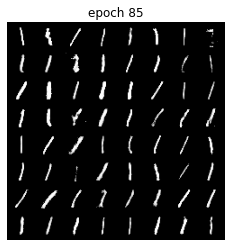

Epoch 85 of 100
Generator loss: 2.62079246, Discriminator loss: 0.34657083


118it [01:55,  1.02it/s]


Epoch 86 of 100
Generator loss: 2.61777774, Discriminator loss: 0.34689172


118it [01:56,  1.01it/s]


Epoch 87 of 100
Generator loss: 2.69321060, Discriminator loss: 0.34018344


118it [01:54,  1.03it/s]


Epoch 88 of 100
Generator loss: 2.65634357, Discriminator loss: 0.34553471


118it [01:54,  1.03it/s]


Epoch 89 of 100
Generator loss: 2.64290494, Discriminator loss: 0.34361507


118it [01:54,  1.03it/s]


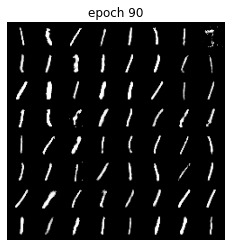

Epoch 90 of 100
Generator loss: 2.70206314, Discriminator loss: 0.33798229


118it [01:54,  1.03it/s]


Epoch 91 of 100
Generator loss: 2.68538823, Discriminator loss: 0.33998857


118it [01:57,  1.01it/s]


Epoch 92 of 100
Generator loss: 2.60800764, Discriminator loss: 0.34813103


118it [01:55,  1.02it/s]


Epoch 93 of 100
Generator loss: 2.65412050, Discriminator loss: 0.34339931


118it [01:57,  1.00it/s]


Epoch 94 of 100
Generator loss: 2.65294944, Discriminator loss: 0.34466769


118it [01:55,  1.03it/s]


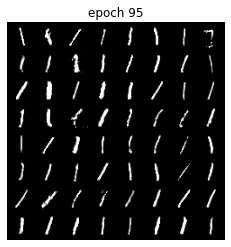

Epoch 95 of 100
Generator loss: 2.66772185, Discriminator loss: 0.34509202


118it [01:56,  1.01it/s]


Epoch 96 of 100
Generator loss: 2.67673347, Discriminator loss: 0.34228417


118it [01:56,  1.02it/s]


Epoch 97 of 100
Generator loss: 2.69344267, Discriminator loss: 0.34288502


118it [01:54,  1.03it/s]


Epoch 98 of 100
Generator loss: 2.58896338, Discriminator loss: 0.34932548


118it [01:54,  1.04it/s]


Epoch 99 of 100
Generator loss: 2.59095275, Discriminator loss: 0.34986428


118it [01:55,  1.02it/s]


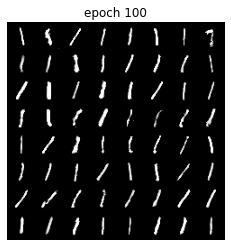

Epoch 100 of 100
Generator loss: 2.62467577, Discriminator loss: 0.34973734


In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        #get the input to device
        data[0].to(device)

        # optimize discriminator
        loss_d_total = 0.0
        for _ in range(num_steps_train_discriminator):
          generator_output = generator(create_noise(len(data[0]), nz)).detach() 
          optim_d.zero_grad()
          
          # .detach() to ensure not part of the graph

          #get the preds from discriminator on fake and true data
          gen_disc_output = discriminator(generator_output)
          true_data_output = discriminator(data[0])

          #optimize the loss
          
          disc_loss_fake, disc_loss_real  = discriminator_loss(gen_disc_output, true_data_output) #between fake and true images
          disc_loss_fake.backward()
          disc_loss_real.backward()
          optim_d.step()

          #increase counter
          loss_d_total += (disc_loss_fake+disc_loss_real).detach().cpu().numpy()
    
        # optimize generator
        optim_g.zero_grad()
        generator_output = generator(create_noise(len(data[0]), nz))
        gen_loss = generator_loss(generator_output)
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.detach().cpu().numpy()
        loss_d += loss_d_total / num_steps_train_discriminator
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

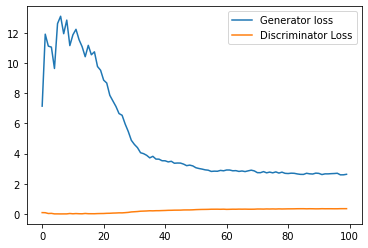

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')